# Comparing RoPE with Sinusoidal Embeddings

We compare in these ways:
1. How is the attention score when the absolute position changes, but relative position doesn't.
2. How is the attention score when the positions are closer vs farther apart?

We compare the following embeddings:
1. No positional embeddings
2. Sinusoidal embeddings
3. RoPE embeddings

In [110]:
import torch
from matplotlib import pyplot as plt

from lex.positional_embeddings.experiments.rope.llama_rope import precompute_freqs_cis, apply_rotary_emb

In [58]:
# Let's create some embeddings first.

dim = 8
vocab_size = 5
max_seq_len = 32
seq_len = 5

embeddings_map = {
    "i": torch.rand(dim),
    "love": torch.rand(dim),
    "dogs": torch.rand(dim),
    "and": torch.rand(dim),
    "cats": torch.rand(dim),
}

In [184]:
# Let's create a function to calculate the attention score.
def attention_score(qs, ks, mask=None):
    # qs: (batch, seq_len, dim)
    # ks: (batch, seq_len, dim)
    # mask: (batch, seq_len, seq_len)
    # Return: (batch, seq_len, seq_len)

    ks_T = ks.transpose(1, 2)  # (batch, dim, seq_len)

    # Compute raw attention scores using dot product
    scores = torch.matmul(qs, ks_T)  # (batch, seq_len, seq_len)

    # Scale by the square root of the dimension
    dim_k = qs.size(-1)
    scaled_scores = scores / torch.sqrt(torch.tensor(dim_k, dtype=torch.float32))

    # Apply mask if provided (use a large negative number for masked positions)
    if mask is not None:
        scaled_scores = scaled_scores.masked_fill(mask == 0, float('-inf'))

    # Compute softmax to get attention weights
    # scaled_scores = torch.softmax(scaled_scores, dim=-1)

    return scaled_scores


# Create a mask for the attention score.
mask = torch.ones(1, 5, 5)
mask = mask.tril()  # (batch, seq_len, seq_len)
mask

tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])

In [185]:
sentence = "i love dogs and cats"
embeddings = torch.stack([embeddings_map[token] for token in sentence.split(" ")]).unsqueeze(0)
embeddings.shape

torch.Size([1, 5, 8])

In [186]:
attention_score(embeddings, embeddings, mask=mask)

tensor([[[0.5695,   -inf,   -inf,   -inf,   -inf],
         [0.5899, 0.7930,   -inf,   -inf,   -inf],
         [0.8894, 0.8344, 1.5451,   -inf,   -inf],
         [0.8474, 0.8302, 1.3757, 1.4384,   -inf],
         [0.8507, 0.8157, 1.4519, 1.4035, 1.4893]]])

These are the raw attention scores with no positional embeddings.

If we change the positions, they are still gonna be the same.

Let's change the positions to "i love cats and dogs".
i.e. the 2nd and 4th tokens are swapped.

In [187]:
sentence = "i love cats and dogs"
embeddings = torch.stack([embeddings_map[token] for token in sentence.split(" ")]).unsqueeze(0)
attention_score(embeddings, embeddings, mask=mask)

tensor([[[0.5695,   -inf,   -inf,   -inf,   -inf],
         [0.5899, 0.7930,   -inf,   -inf,   -inf],
         [0.8507, 0.8157, 1.4893,   -inf,   -inf],
         [0.8474, 0.8302, 1.4035, 1.4384,   -inf],
         [0.8894, 0.8344, 1.4519, 1.3757, 1.5451]]])

The attention value at `(4, 2)` before and after is the same.

So here positions don't matter. They are a bag of tokens.

**Attention vs Position**

We should expect equal attention at all positions.

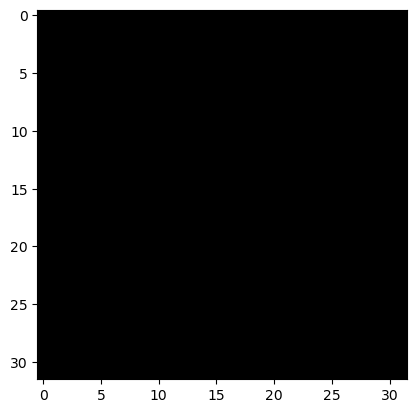

In [188]:
tokens = ["dogs"] * 32
embeddings = torch.stack([embeddings_map[token] for token in tokens]).unsqueeze(0)
scores = attention_score(embeddings, embeddings)
plt.imshow(scores[0], cmap="gray")

## Using Sinusoidal Embeddings

torch.Size([32, 8])


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
          9.9980e-01,  2.0000e-03,  1.0000e+00],
        [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,
          9.9955e-01,  3.0000e-03,  1.0000e+00],
        [-7.5680e-01, -6.5364e-01,  3.8942e-01,  9.2106e-01,  3.9989e-02,
          9.9920e-01,  4.0000e-03,  9.9999e-01],
        [-9.5892e-01,  2.8366e-01,  4.7943e-01,  8.7758e-01,  4.9979e-02,
          9.9875e-01,  5.0000e-03,  9.9999e-01],
        [-2.7942e-01,  9.6017e-01,  5.6464e-01,  8.2534e-01,  5.9964e-02,
          9.9820e-01,  6.0000e-03,  9.9998e-01],
        [ 6.5699e-01,  7.5390e-01,  6.4422e-01,  7.6484e-01,  6.9943e-02,
          9.9755e-01,  6.9999e-03,  9.9998e-01],
        [ 9.8936

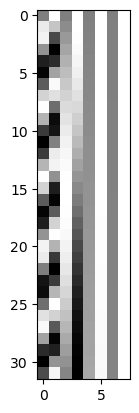

In [189]:
pe = torch.zeros(max_seq_len, dim)
position = torch.arange(0, max_seq_len).unsqueeze(1)
div_term = torch.exp((torch.arange(0, dim, 2, dtype=torch.float) * -(torch.log(torch.tensor(10000.0)) / dim)))
pe[:, 0::2] = torch.sin(position.float() * div_term)
pe[:, 1::2] = torch.cos(position.float() * div_term)

plt.imshow(pe, cmap="gray")

print(pe.shape)
pe

In [190]:
sentence = "i love dogs and cats"
embeddings = torch.stack([embeddings_map[token] for token in sentence.split(" ")]).unsqueeze(0)
embeddings.shape

torch.Size([1, 5, 8])

In [191]:
embeddings_sinusoidal = embeddings + pe[:seq_len].unsqueeze(0)
embeddings_sinusoidal.shape

torch.Size([1, 5, 8])

In [192]:
attention_score(embeddings_sinusoidal, embeddings_sinusoidal, mask=mask)

tensor([[[3.2242,   -inf,   -inf,   -inf,   -inf],
         [3.0212, 3.2669,   -inf,   -inf,   -inf],
         [3.4471, 3.6114, 5.0528,   -inf,   -inf],
         [2.8961, 2.9469, 4.4883, 4.6725,   -inf],
         [3.0036, 2.8163, 4.2608, 4.4612, 4.5511]]])

"cats" attention to "dogs" is in [4, 2] position.

In [193]:
sentence = "dogs and cats i love"
embeddings = torch.stack([embeddings_map[token] for token in sentence.split(" ")]).unsqueeze(0)
embeddings_sinusoidal = embeddings + pe[:seq_len].unsqueeze(0)
attention_score(embeddings_sinusoidal, embeddings_sinusoidal, mask=mask)

tensor([[[5.3133,   -inf,   -inf,   -inf,   -inf],
         [4.8493, 5.0376,   -inf,   -inf,   -inf],
         [4.3698, 4.8248, 5.1359,   -inf,   -inf],
         [3.0300, 3.2754, 3.5300, 2.6971,   -inf],
         [2.9919, 2.9075, 2.8466, 2.3444, 2.5500]]])

"cats" attention to "dogs" is in [2, 0] position.

Here, the absolute positions have changed, but the relative positions didn't.
However, the attention score has changed.

**Attention vs Distance**

Let's check how the attention changes with distance.

I'll take the sentence "dogs dogs dogs ...".
Then it's easy to check the attention score at different positions.

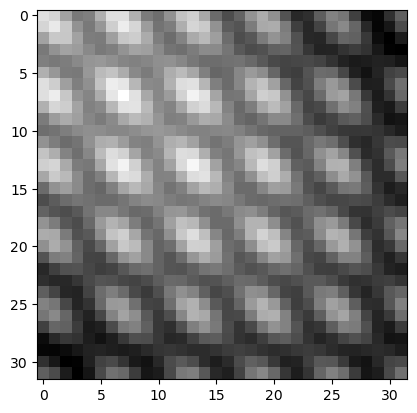

In [194]:
tokens = ["dogs"] * 32
embeddings = torch.stack([embeddings_map[token] for token in tokens]).unsqueeze(0)
embeddings_sinusoidal = embeddings + pe[:len(tokens)].unsqueeze(0)
scores = attention_score(embeddings_sinusoidal, embeddings_sinusoidal)
plt.imshow(scores[0], cmap="gray")

The attention has a pattern, but there's little dependency to the distance.

Ideally, we want higher attention to closer tokens and lower attention to farther tokens.

## Using RoPE

In [195]:
cis = precompute_freqs_cis(dim, max_seq_len)
cis.shape

torch.Size([32, 4])

In [196]:
sentence = "i love dogs and cats"
embeddings = torch.stack([embeddings_map[token] for token in sentence.split(" ")]).unsqueeze(0).unsqueeze(2)
embeddings.shape

torch.Size([1, 5, 1, 8])

In [197]:
embeddings_rope, _ = apply_rotary_emb(embeddings, embeddings, cis[:seq_len])
embeddings_rope = embeddings_rope.squeeze(2)

print(embeddings_rope[0])

embeddings_rope.shape

tensor([[ 0.1506,  0.4874,  0.7031,  0.4262,  0.4590,  0.3789,  0.3272,  0.4617],
        [-0.5493,  0.5731,  0.7705,  0.8468,  0.4390,  0.0411,  0.3261,  0.0378],
        [-0.7513,  0.1167,  0.6008,  0.9337,  0.4943,  1.0006,  0.6976,  0.9096],
        [-0.3925, -0.2282,  0.6162,  1.2312,  0.8126,  0.6674,  0.2123,  0.9033],
        [-0.2224, -0.5411,  0.5281,  1.2451,  0.5131,  0.7162,  0.6609,  0.9100]])


torch.Size([1, 5, 8])

In [198]:
attention_score(embeddings_rope, embeddings_rope, mask=mask)

tensor([[[0.5695,   -inf,   -inf,   -inf,   -inf],
         [0.5093, 0.7930,   -inf,   -inf,   -inf],
         [0.7136, 0.7966, 1.5451,   -inf,   -inf],
         [0.6718, 0.7388, 1.3531, 1.4384,   -inf],
         [0.6180, 0.6285, 1.3586, 1.3882, 1.4893]]])

The attention score of "cats" on "dogs" is in [4, 2] position.

In [199]:
sentence = "dogs and cats i love"
embeddings = torch.stack([embeddings_map[token] for token in sentence.split(" ")]).unsqueeze(0).unsqueeze(2)
embeddings_rope, _ = apply_rotary_emb(embeddings, embeddings, cis[:seq_len])
embeddings_rope = embeddings_rope.squeeze(2)
attention_score(embeddings_rope, embeddings_rope, mask=mask)

tensor([[[1.5451,   -inf,   -inf,   -inf,   -inf],
         [1.3531, 1.4384,   -inf,   -inf,   -inf],
         [1.3586, 1.3882, 1.4893,   -inf,   -inf],
         [0.6346, 0.7225, 0.7575, 0.5695,   -inf],
         [0.5401, 0.6101, 0.5613, 0.5093, 0.7930]]])

Attention of "cats" on "dogs" is in [2, 0] position.

This is exactly the same value as "i love dogs and cats" sentence.

**Attention vs Distance**

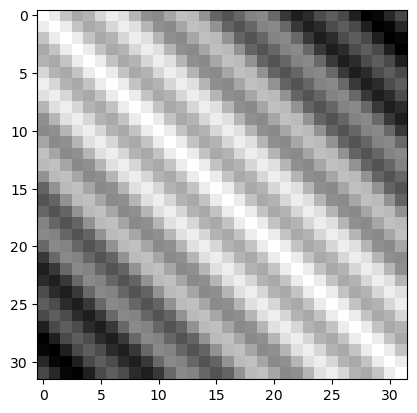

In [200]:
tokens = ["dogs"] * 32
embeddings = torch.stack([embeddings_map[token] for token in tokens]).unsqueeze(0).unsqueeze(2)
embeddings_rope, _ = apply_rotary_emb(embeddings, embeddings, cis)
embeddings_rope = embeddings_rope.squeeze(2)
scores = attention_score(embeddings_rope, embeddings_rope)
plt.imshow(scores[0], cmap="gray")

The attention score is loosely dependent on the distance.

Although it is not monotonous decay, it is better than sinusoidal embeddings.